In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils
from pathlib import Path

In [215]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.reload_library()
import matplotlib.patches as mpatches

In [22]:
result_path = Path("../../results/")

In [96]:
solvents_inchies = [GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY]
solvents = [INCHI_TO_CHEMNAME[inchie] for inchie in solvents_inchies]

In [97]:
keywords = ["rf", INCHI_TO_CHEMNAME[GBL_INCHI_KEY]]

In [98]:
def load_files_containing(dir_src_path, key_words, extension='csv'):
    files = [file_path for file_path in dir_src_path.iterdir() \
                if all(keyword in file_path.as_posix() for keyword in key_words)]
    return files

In [99]:
files_solvent_exp = load_files_containing(result_path, key_words=keywords)

In [100]:
def load_melted_classi_report(path):
    hue_1 = 'only_GBL'
    report_index = ['No cristaliza', 'Cristaliza', 'accuracy',
                    'macro avg', 'weighted avg'] 
    df = pd.read_csv(path)
    df['Clase'] = report_index
    df = df.melt(id_vars=['Clase'], 
                 value_vars=['precision', 'recall','f1-score', 'support'],
                 value_name='Score', var_name='Métrica'
                )
    df['Tipo'] = 'monosolvente (GBL) ' if hue_1 in path.as_posix() \
                                        else 'multisolvente'
    return df

In [101]:
merge_class_report = pd.concat([load_melted_classi_report(file) for file 
                                                    in files_solvent_exp],
                               axis=0)

In [102]:
merge_class_report[['Tipo']].value_counts()

Tipo               
monosolvente (GBL)     340
multisolvente          300
dtype: int64

In [103]:
merge_class_report = merge_class_report[merge_class_report['Métrica'] != 'support']

In [105]:
merge_class_report.head()

,Clase,Métrica,Score,Tipo
0,No cristaliza,precision,0.923924,multisolvente
1,Cristaliza,precision,0.795455,multisolvente
2,accuracy,precision,0.900738,multisolvente
3,macro avg,precision,0.859689,multisolvente
4,weighted avg,precision,0.897471,multisolvente


In [113]:
merge_class_report_by_class = merge_class_report.loc[merge_class_report['Clase']\
                                                .isin(['No cristaliza','Cristaliza'])]

In [225]:
with plt.style.context(['science', 'light']):
    light = sns.color_palette()

In [223]:
light

[(0.4666666666666667, 0.6666666666666666, 0.8666666666666667),
 (0.9333333333333333, 0.5333333333333333, 0.4),
 (0.9333333333333333, 0.8666666666666667, 0.5333333333333333),
 (1.0, 0.6666666666666666, 0.7333333333333333),
 (0.6, 0.8666666666666667, 1.0),
 (0.26666666666666666, 0.7333333333333333, 0.6),
 (0.7333333333333333, 0.8, 0.2),
 (0.6666666666666666, 0.6666666666666666, 0.0),
 (0.8666666666666667, 0.8666666666666667, 0.8666666666666667)]

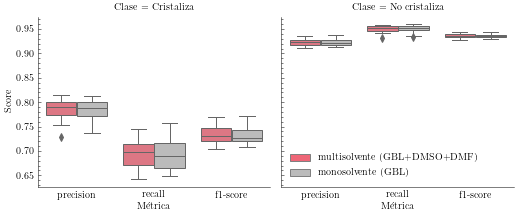

In [220]:
plot_title = "../../figures/boxplot_solvent_exp.pdf"

with plt.style.context(['science', 'bright']):
    g = sns.catplot(x="Métrica", y="Score",
                hue="Tipo", col='Clase', col_wrap=2, height=3, aspect=1.2,
                col_order=["Cristaliza", "No cristaliza"], palette=[bright.red, bright.grey],
                kind='box', sharey=True, sharex=True, data=merge_class_report_by_class, legend=False)
    for ax in g.axes:
        #ax.set_yticklabels(rotation=90)
        ax.tick_params(labelbottom=True, which="both", left=True, bottom=False, top=False, right=False)
    plt.subplots_adjust(bottom=0.1, left=0.06, hspace=0.2)
    pop_a = mpatches.Patch(facecolor=bright.red, label="multisolvente (GBL+DMSO+DMF)", edgecolor='grey')
    pop_b = mpatches.Patch(facecolor=bright.grey, label="monosolvente (GBL)", edgecolor='grey')

    plt.legend(handles=[pop_a,pop_b])

    #plt.legend(title='', labels=["multisolvente (GBL+DMSO+DMF)", "monosolvente (GBL)"], facecolor=True)
    plt.savefig(plot_title, dpi=300)
    plt.show()